In [58]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#load dynamics from log file
def load_from_file(file_name, dt):
    v = numpy.loadtxt(file_name)

    #u = numpy.array(v[:, 1:3])
    u = numpy.array(v[:, 3:5])
    x = numpy.array(v[:, 5:7])

    t = numpy.arange(x.shape[0])*dt
    
    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x):   
    #zero initial conditions
    x_aug = x - x[0]

    vel = difference(x_aug[:, 0:2])

    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1):

    plt.clf()

    axis_count = 4
    if x_ref.shape[1] == 4:
        axis_count+= 2

    fig, axs = plt.subplots(axis_count, 1, figsize=(8, 2*5))


    u_result*= 60.0/(2.0*numpy.pi)


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control left")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control right")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1]*180.0/numpy.pi, color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1]*180.0/numpy.pi, color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [deg]")
    axs[3].grid()


    if axis_count == 6:
        axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2], label="ground truth", color="red")
        axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2], label="prediction", color="blue")
        axs[4].set_xlabel("time [s]")
        axs[4].set_ylabel("distance velocity")
        axs[4].legend()
        axs[4].grid()

        axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3]*180.0/numpy.pi, color="red")
        axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3]*180.0/numpy.pi, color="blue")
        axs[5].set_xlabel("time [s]")
        axs[5].set_ylabel("angle velocity")
        axs[5].grid()
        
    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [59]:
#obtain model
dt = 1.0/250.0
u_result, x_result, t_result = load_from_file("./data/run_0.log", dt)


#normalise speed

x_ref = state_augmentation(x_result.copy())

 


#identification
a_est, b_est = LibsControl.recursive_ls_identification(u_result, x_ref)
    
c_est = numpy.zeros((a_est.shape[0], a_est.shape[0]))
for n in range(a_est.shape[0]):
    c_est[n][n] = 1.0


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")



'''
#model symmetrization

x_flip = numpy.flip(x_result.copy(), axis=1)
u_flip = numpy.flip(u_result.copy(), axis=1)

x_flip = state_augmentation(x_flip)

#identification
a_est_flip, b_est_flip = LibsControl.recursive_ls_identification(u_flip, x_flip)

print("mat_a_flip = \n", a_est_flip, "\n\n")
print("mat_b_flip = \n", b_est_flip, "\n\n")

#one model rule them all
a_est = (a_est + a_est_flip)/2
b_est = (b_est + b_est_flip)/2



print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
'''

n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]


mat_a = 
 [[ 9.99694854e-01 -2.47262012e-03  7.17375390e-01  4.18556665e+00]
 [ 2.34418704e-08  1.00002753e+00  1.52411749e-03  2.03105675e-01]
 [-3.05146453e-04 -2.47262012e-03  7.17375390e-01  4.18556665e+00]
 [ 2.34420793e-08  2.75330257e-05  1.52411607e-03  2.03106303e-01]] 


mat_b = 
 [[ 4.53088487  1.92401535]
 [-0.2135496   0.18302795]
 [ 4.53088487  1.92401535]
 [-0.21354944  0.18302781]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 




<Figure size 640x480 with 0 Axes>

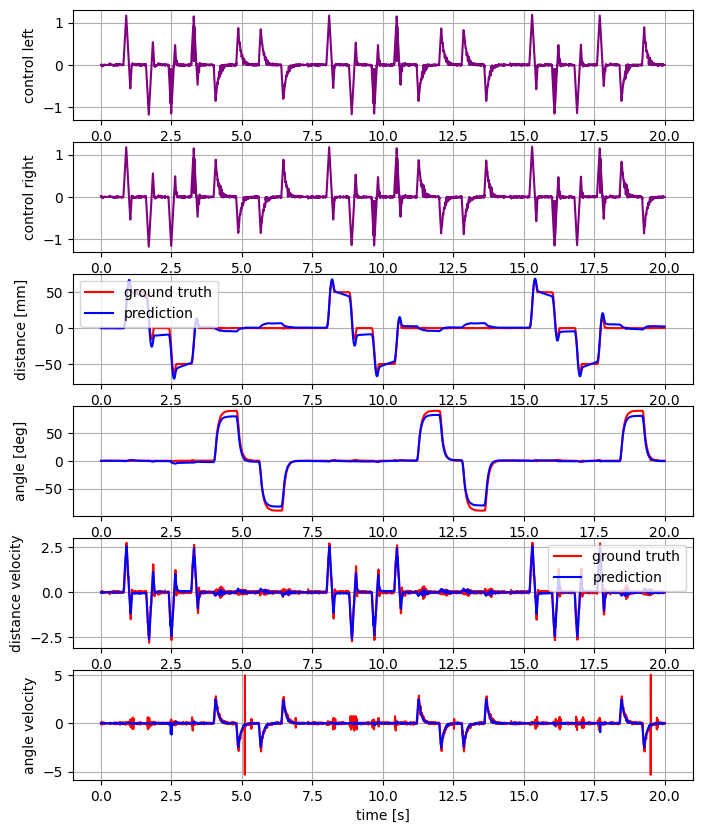

In [60]:
#model verification
#set same inputs and initial conditions

ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)


#plot results
plot_results(t_result, u_result, x_ref, x_hat_result, 0, 5000)


In [61]:
#controller synthetis

#controller synthetis

#process and observation noise covariance
q_noise = 0.1*numpy.eye(a_est.shape[0]) 
r_noise = 0.1*numpy.eye(c_est.shape[0]) 
 

#create loss weighting matrices (diagonal)
q = numpy.diag([ 10**-6, 10**-5, 0.0, 0.0] )
r = numpy.diag( [1.0, 1.0])  

antiwindup = 1.0

#solve LQG controller
lqg = LibsControl.LQGDiscrete(a_est, b_est, c_est, q, r, q_noise, r_noise, antiwindup)

print("controller")
print("k  = \n", lqg.k, "\n")
print("ki = \n", lqg.ki, "\n")
print("ki = \n", lqg.ki, "\n")
print("f  = \n", lqg.f, "\n")
print("\n\n")


print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqg.k))



controller
k  = 
 [[ 0.01111224 -0.08381365  0.02097094  0.12868125]
 [ 0.00924416  0.11091346  0.0189908   0.16063412]] 

ki = 
 [[ 0.00086349 -0.00197526  0.          0.        ]
 [ 0.00066781  0.00256527  0.          0.        ]] 

ki = 
 [[ 0.00086349 -0.00197526  0.          0.        ]
 [ 0.00066781  0.00256527  0.          0.        ]] 

f  = 
 [[7.76405393e-01 6.78976216e-03 1.86548446e-01 7.99591802e-03]
 [6.78976216e-03 6.18482569e-01 9.09336989e-03 5.55415476e-04]
 [1.86548446e-01 9.09336989e-03 7.54057830e-01 1.23230175e-02]
 [7.99591802e-03 5.55415476e-04 1.23230175e-02 5.00792827e-01]] 




poles OL =  [0.19098098 0.73031892 0.99887033 1.00003385]
poles CL =  [0.19147428+0.j         0.76869023+0.10159945j 0.76869023-0.10159945j
 0.95154033+0.j        ]


<Figure size 640x480 with 0 Axes>

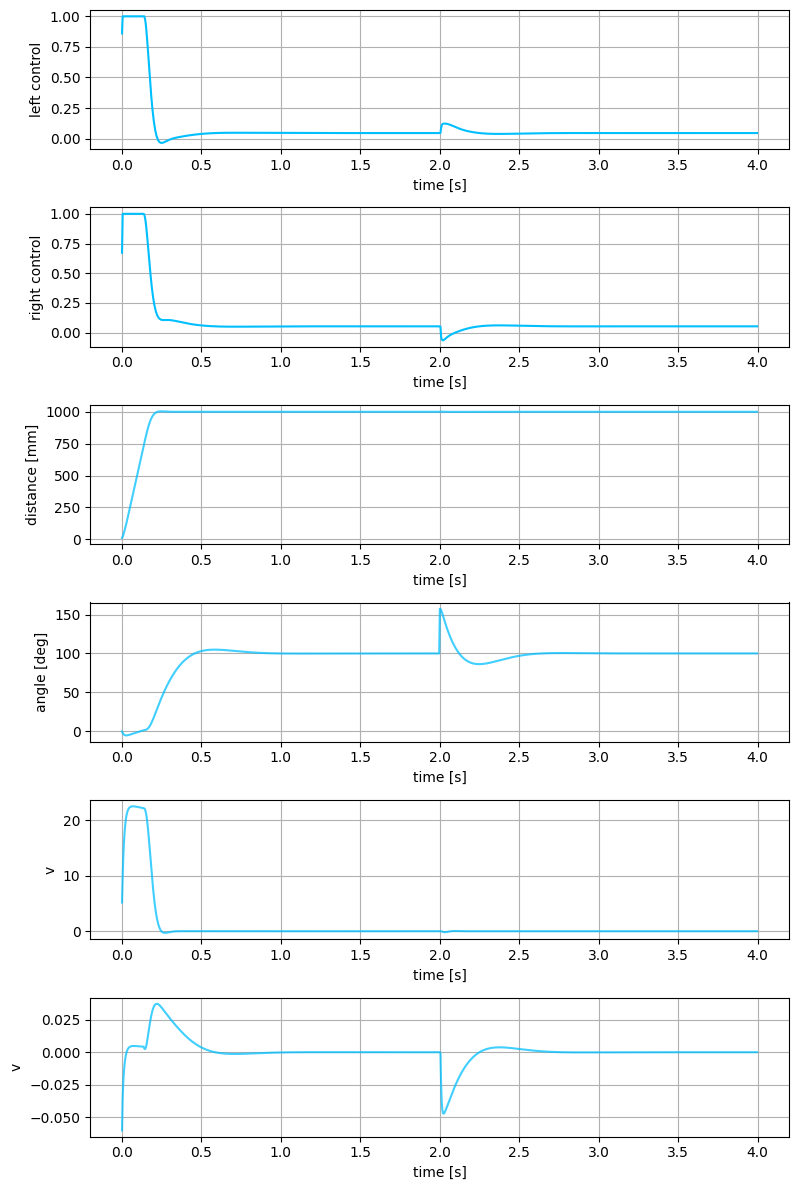

In [62]:
#process simulation

n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
yr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T

#plant state
y     = numpy.zeros((c_est.shape[0], 1))

x_hat = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []



for n in range(n_max):

    #compute controller output
    u, integral_action, x_hat = lqg.forward(yr, y, integral_action, x_hat)

    #disturbance
    '''
    if n > n_max//2:
        u[0, :]+= 50
        u[1, :]+= 100
    '''

    if n == n_max//2:
        x[0, 0]+= 1 
        x[1, 0]+= 1
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)
x_result = numpy.array(x_result)

int_result = numpy.array(int_result)



#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqr_discrete_output.png", u_labels = ["left control", "right control"], x_labels = ["distance [mm]", "angle [deg]", "v", "v"])




In [63]:
#print c-like arrays

print(matrix_to_c("mat_a", a_est))
print(matrix_to_c("mat_b", b_est))
print(matrix_to_c("mat_c", c_est))
print(matrix_to_c("k", lqg.k))
print(matrix_to_c("ki", lqg.ki))
print(matrix_to_c("f", lqg.f))

float mat_a[] = {
		0.9996948, -0.0024726202, 0.7173754, 4.1855664, 
		2.344187e-08, 1.0000275, 0.0015241175, 0.20310567, 
		-0.00030514644, -0.0024726202, 0.7173754, 4.1855664, 
		2.3442079e-08, 2.7533026e-05, 0.001524116, 0.2031063 };

float mat_b[] = {
		4.5308847, 1.9240154, 
		-0.2135496, 0.18302794, 
		4.5308847, 1.9240154, 
		-0.21354944, 0.1830278 };

float mat_c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

float k[] = {
		0.0111122355, -0.08381365, 0.02097094, 0.12868126, 
		0.009244162, 0.110913455, 0.018990804, 0.16063412 };

float ki[] = {
		0.00086349266, -0.0019752574, 0.0, 0.0, 
		0.0006678071, 0.0025652659, 0.0, 0.0 };

float f[] = {
		0.7764054, 0.006789762, 0.18654844, 0.007995918, 
		0.006789762, 0.6184826, 0.00909337, 0.00055541546, 
		0.18654844, 0.00909337, 0.7540578, 0.012323017, 
		0.007995918, 0.00055541546, 0.012323017, 0.5007928 };

